Importing Needed Libraries

In [ ]:
# imports necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss, accuracy_score, multilabel_confusion_matrix

Import Datasets

In [54]:
# imports csv data to pandas dataframe
data = pd.read_csv('Data.csv', index_col=0)

# removes NAN values from dataframe
data.dropna(inplace=True)

# combines Normal samples to reduce the amount of them
normal = data.query("status=='Normal'")['statement'].values
print(len(normal))
new_normal = []
collect = ''
j = 1
for i in normal:
    #print(collect)
    collect = collect + ' ' + str(i)
    if (j%5) == 0:
        #print(j)
        new_normal.append(collect)
        collect = ''
    j += 1
new_normal.append(collect)
print(len(new_normal))

# combines Depression samples to reduce amount of them
depression = data.query("status=='Depression'")['statement'].values
new_depression = []
collect = ''
j = 1
for i in depression:
    collect = collect + ' ' + i
    if j%5 == 0:
        new_depression.append(collect)
        collect = ''
    j += 1
new_depression.append(collect)

# combines Suicidal samples to reduce amount of them
suicidal = data.query("status=='Suicidal'")['statement'].values
new_suicidal = []
collect = ''
j = 1
for i in suicidal:
    collect = collect + ' ' + i
    if j%3 == 0:
        new_suicidal.append(collect)
        collect = ''
    j += 1
new_suicidal.append(collect)

# gets all the statements, currently not getting bipolar or personality disorder in attempt to reduce complexity
text = []
text.extend(data.query("status=='Anxiety'")['statement'].values)
#text.extend(data.query("status=='Bipolar'")['statement'].values)
text.extend(data.query("status=='Stress'")['statement'].values)
#text.extend(data.query("status=='Personality disorder'")['statement'].values)
text.extend(new_normal)
text.extend(new_depression)
text.extend(new_suicidal)

# start building dataframe
full_kaggle = pd.DataFrame()
#full_kaggle['text'] = data['statement'].values
full_kaggle['text'] = text
#print(full_kaggle)

# re defines statuses after changes to depression, normal, bipolar, and personality disorder
statuses = []
for i in range(len(data.query("status=='Anxiety'")['statement'].values)):
    statuses.append('Anxiety')
#for i in range(len(data.query("status=='Bipolar'")['statement'].values)):
#    statuses.append('Bipolar')
for i in range(len(data.query("status=='Stress'")['statement'].values)):
    statuses.append('Stress')
#for i in range(len(data.query("status=='Personality disorder'")['statement'].values)):
#    statuses.append('Personality disorder')
for i in range(len(new_normal)):
    statuses.append('Normal')
for i in range(len(new_depression)):
    statuses.append('Depression')
for i in range(len(new_suicidal)):
    statuses.append('Suicidal')

# sets up labels for multilabeling, if not that status 0, 1 if it is that status
norm = []
dep = []
sui = []
anx = []
bi = []
st = []
pers = []
for i in statuses:
    if i == "Normal":
        norm.append(1)
    else:
        norm.append(0)
    if i == "Depression":
        dep.append(1)
    else:
        dep.append(0)
    if i == "Suicidal":
        sui.append(1)
    else:
        sui.append(0)
    if i == "Anxiety":
        anx.append(1)
    else:
        anx.append(0)
    #if i == "Bipolar":
    #    bi.append(1)
    #else:
    #    bi.append(0)
    if i == "Stress":
        st.append(1)
    else:
        st.append(0)
    #if i == "Personality disorder":
    #    pers.append(1)
    #else:
    #    pers.append(0)

# add new labels to dataset
full_kaggle['Normal'] = norm
full_kaggle['Depression'] = dep
full_kaggle['Suicidal'] = sui
full_kaggle['Anxiety'] = anx
#full_kaggle['Bipolar'] = bi
full_kaggle['Stress'] = st
#full_kaggle['Personality disorder'] = pers

print(full_kaggle.head())

16343
3269
                                                text  Normal  Depression  \
0                                         oh my gosh       0           0   
1  trouble sleeping, confused mind, restless hear...       0           0   
2  All wrong, back off dear, forward doubt. Stay ...       0           0   
3  I've shifted my focus to something else but I'...       0           0   
4  I'm restless and restless, it's been a month n...       0           0   

   Suicidal  Anxiety  Stress  
0         0        1       0  
1         0        1       0  
2         0        1       0  
3         0        1       0  
4         0        1       0  


Clean Data Function

In [29]:
stemmer = PorterStemmer()

# function used to remove unwanted patterns (url, punctuation, etc)
def rPatterns(text):
    # removes URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # removes mark-down links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # removes handles
    text = re.sub(r'@\w+', '', text)

    # removes punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# used for stemming words
def stem_words(words):
    return ' '.join(stemmer.stem(str(word)) for word in words)

def clean_data(data):
    # main code used for cleaning up csv:

    # changes everything to lowercase
    data['cleaned_text'] = data['text'].str.lower()

    # removes unwanted text (punctuation, urls, etc.)
    data['cleaned_text'] = data['cleaned_text'].apply(rPatterns)

    # performs tokenization (split sentences into list of words)
    data['cleaned_text'] = data['cleaned_text'].apply(word_tokenize)

    # performs stemming (reduce words to their base/root form)
    data['cleaned_text'] = data['cleaned_text'].apply(stem_words)

    return data

In [55]:
# cleans data
cleaned_kaggle = clean_data(full_kaggle)
print(cleaned_kaggle.head())

                                                text  Normal  Depression  \
0                                         oh my gosh       0           0   
1  trouble sleeping, confused mind, restless hear...       0           0   
2  All wrong, back off dear, forward doubt. Stay ...       0           0   
3  I've shifted my focus to something else but I'...       0           0   
4  I'm restless and restless, it's been a month n...       0           0   

   Suicidal  Anxiety  Stress  \
0         0        1       0   
1         0        1       0   
2         0        1       0   
3         0        1       0   
4         0        1       0   

                                        cleaned_text  
0                                         oh my gosh  
1  troubl sleep confus mind restless heart all ou...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shift my focu to someth els but im still w...  
4  im restless and restless it been a month now b...  


Reading in and Creating Ao3 Dataset

In [ ]:
# gets training dataset
train_df = pd.DataFrame()
with open('new_28_train.jsonl', mode='r', encoding='utf-8') as inf:
    train_df = pd.read_json(inf, lines=True)

# gets validation dataset
val_df = pd.DataFrame()
with open('validation.jsonl', mode='r', encoding='utf-8') as inf:
    val_df = pd.read_json(inf, lines=True)

# gets testing dataset
test_df = pd.DataFrame()
with open('test.jsonl', mode='r', encoding='utf-8') as inf:
    test_df = pd.read_json(inf, lines=True)

# combines all of the datasets, will redefine 
new_df = pd.concat([train_df, val_df], ignore_index=True)
new_df = pd.concat([new_df, test_df], ignore_index=True)

# saves text values
txt_vals = new_df['text'].astype(str).values

# saves trigger warning labels
new_ys = new_df['warnings_coarse_open'].values

# initialize new dataframe and add text values
full_ao3 = pd.DataFrame()
full_ao3['text'] = txt_vals

# gets labels in a way that works for multilabeling
dis = []
agg = []
ab = []
preg = []
med = []
mh = []
sc = []
for i in new_ys:
    if "discrimination" in i:
        dis.append(1)
    else:
        dis.append(0)
    if "aggression" in i:
        agg.append(1)
    else:
        agg.append(0)
    if "abuse" in i:
        ab.append(1)
    else:
        ab.append(0)
    if "pregnancy" in i:
        preg.append(1)
    else:
        preg.append(0)
    if "medical" in i:
        med.append(1)
    else:
        med.append(0)
    if "mental-health" in i:
        mh.append(1)
    else:
        mh.append(0)
    if "sexual-content" in i:
        sc.append(1)
    else:
        sc.append(0)

# adds all of these new labels
full_ao3['discrimination'] = dis
full_ao3['aggresion'] = agg
full_ao3['abuse'] = ab
full_ao3['pregnancy'] = preg
full_ao3['medical'] = med
full_ao3['mental-health'] = mh
full_ao3['sexual-content'] = sc

# for confirming correct sizes (for debugging purposes)
print(full_ao3.head())
print(full_ao3.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

['sexual-content', 'discrimination']
                                                text  discrimination  \
0  ['<div class="userstuff"><p>Dean isn’t sure ho...               1   
1  ['<div class="userstuff"><p><em> I’ve put the ...               0   
2  ['<div class="userstuff module" role="article"...               1   
3  ['<div class="userstuff"><p>Matt settled in th...               0   
4  ['<div class="userstuff module" role="article"...               1   

   aggresion  abuse  pregnancy  medical  mental-health  sexual-content  
0          0      0          0        0              0               1  
1          0      1          0        0              0               1  
2          1      1          0        0              1               0  
3          0      0          0        0              1               0  
4          1      1          0        1              1               0  
(14569, 8)
(7182, 3)
(3895, 3)
(3492, 3)


Clean Ao3 Dataset

In [ ]:
# call function to clean the text
cleaned_ao3 = clean_data(full_ao3)
print(cleaned_ao3.head())

                                                text  discrimination  \
0  ['<div class="userstuff"><p>Dean isn’t sure ho...               1   
1  ['<div class="userstuff"><p><em> I’ve put the ...               0   
2  ['<div class="userstuff module" role="article"...               1   
3  ['<div class="userstuff"><p>Matt settled in th...               0   
4  ['<div class="userstuff module" role="article"...               1   

   aggresion  abuse  pregnancy  medical  mental-health  sexual-content  \
0          0      0          0        0              0               1   
1          0      1          0        0              0               1   
2          1      1          0        0              1               0   
3          0      0          0        0              1               0   
4          1      1          0        1              1               0   

                                        cleaned_text  
0  div classuserstuffpdean isnt sure how he got b...  
1  div class

Export Cleaned Dataset

In [101]:
with open('cleaned_new_tvt_data.jsonl', 'w', encoding='utf-8') as f:
    f.write(cleaned_ao3.to_json(orient='records', lines=True, force_ascii=False))

Import Cleaned Dataset (to keep from long run time)

In [31]:
with open('cleaned_new_tvt_data.jsonl', mode='r', encoding='utf-8') as inf:
    cleaned_ao3 = pd.read_json(inf, lines=True)
print(cleaned_ao3)

                                                    text  discrimination  \
0      ['<div class="userstuff"><p>Dean isn’t sure ho...               1   
1      ['<div class="userstuff"><p><em> I’ve put the ...               0   
2      ['<div class="userstuff module" role="article"...               1   
3      ['<div class="userstuff"><p>Matt settled in th...               0   
4      ['<div class="userstuff module" role="article"...               1   
...                                                  ...             ...   
14564  ['<div class="userstuff module" role="article"...               0   
14565  ['<div class="userstuff"><p>Blaine was sprawle...               0   
14566  ['<div class="userstuff"><p>&nbsp;</p><p>“If i...               0   
14567  ['<div class="userstuff"><p>One of the things ...               0   
14568  ['<div class="userstuff"><p>The man is shiveri...               0   

       aggresion  abuse  pregnancy  medical  mental-health  sexual-content  \
0        

Combine Datasets (easiest method of doing this)

In [56]:
# gets all of the cleaned text values
text_arr = np.concatenate((cleaned_kaggle['cleaned_text'], cleaned_ao3['cleaned_text']))
all_text = list(text_arr)

# adjusts label values to account for new samples from the ao3 dataset
norm = list(cleaned_kaggle['Normal'].values)
dep = list(cleaned_kaggle['Depression'].values)
sui = list(cleaned_kaggle['Suicidal'].values)
anx = list(cleaned_kaggle['Anxiety'].values)
st = list(cleaned_kaggle['Stress'].values)
for i in range(len(cleaned_ao3['cleaned_text'].values)):
    norm.append(0)
    dep.append(0)
    sui.append(0)
    anx.append(0)
    st.append(0)

# adjusts for new samples from the kaggle dataset
dis = []
agg = []
ab = []
preg = []
med = []
mh = []
sc = []
for i in range(len(cleaned_kaggle['cleaned_text'].values)):
    dis.append(0)
    agg.append(0)
    ab.append(0)
    preg.append(0)
    med.append(0)
    mh.append(0)
    sc.append(0)

dis.extend(cleaned_ao3['discrimination'].values)
agg.extend(cleaned_ao3['aggresion'].values)
ab.extend(cleaned_ao3['abuse'].values)
preg.extend(cleaned_ao3['pregnancy'].values)
med.extend(cleaned_ao3['medical'].values)
mh.extend(cleaned_ao3['mental-health'].values)
sc.extend(cleaned_ao3['sexual-content'].values)

# combine all of it into new dataset
full_datasets = pd.DataFrame()
full_datasets['text'] = all_text
full_datasets['Normal'] = norm
full_datasets['Depression'] = dep
full_datasets['Suicidal'] = sui
full_datasets['Anxiety'] = anx
full_datasets['Stress'] = st
full_datasets['Discrimination'] = dis
full_datasets['Aggression'] = agg
full_datasets['Abuse'] = ab
full_datasets['Pregnancy'] = preg
full_datasets['Medical'] = med
full_datasets['Mental-Health'] = mh
full_datasets['Sexual-Content'] = sc

print(full_datasets.head())

                                                text  Normal  Depression  \
0                                         oh my gosh       0           0   
1  troubl sleep confus mind restless heart all ou...       0           0   
2  all wrong back off dear forward doubt stay in ...       0           0   
3  ive shift my focu to someth els but im still w...       0           0   
4  im restless and restless it been a month now b...       0           0   

   Suicidal  Anxiety  Stress  Discrimination  Aggression  Abuse  Pregnancy  \
0         0        1       0               0           0      0          0   
1         0        1       0               0           0      0          0   
2         0        1       0               0           0      0          0   
3         0        1       0               0           0      0          0   
4         0        1       0               0           0      0          0   

   Medical  Mental-Health  Sexual-Content  
0        0              0     

Saves Full Cleaned Dataset to File

In [57]:
with open('all_cleaned_tvt_data.jsonl', 'w', encoding='utf-8') as f:
    f.write(full_datasets.to_json(orient='records', lines=True, force_ascii=False))

Optional Import of Full Cleaned Dataset

In [3]:
with open('all_cleaned_tvt_data.jsonl', 'r', encoding='utf-8') as f:
    full_datasets = pd.read_json(f, lines=True)

Remove a bunch of samples that only have sexual-content tag

In [58]:
count = 0
for index, row in full_datasets.iterrows():
    if count == 5000:
        break
    if row['Sexual-Content'] == 1:
        if row['Discrimination'] == 0 and row['Abuse'] == 0 and row['Aggression'] == 0 and row['Medical'] == 0 and row['Mental-Health'] == 0 and row['Pregnancy'] == 0:
            full_datasets.drop(index, inplace=True)

# following prints number of samples that represent each label for analyzing dataset and debugging
print(f'abuse: {full_datasets['Abuse'].value_counts().get(1, 0)}')
print(f'aggression: {full_datasets['Aggression'].value_counts().get(1, 0)}')
print(f'anxiety: {full_datasets['Anxiety'].value_counts().get(1, 0)}')
print(f'depression: {full_datasets['Depression'].value_counts().get(1, 0)}')
print(f'discrimination: {full_datasets['Discrimination'].value_counts().get(1, 0)}')
print(f'medical: {full_datasets['Medical'].value_counts().get(1, 0)}')
print(f'mental-health: {full_datasets['Mental-Health'].value_counts().get(1, 0)}')
print(f'normal: {full_datasets['Normal'].value_counts().get(1, 0)}')
print(f'pregnancy: {full_datasets['Pregnancy'].value_counts().get(1, 0)}')
print(f'sexual-content: {full_datasets['Sexual-Content'].value_counts().get(1, 0)}')
print(f'suicidal: {full_datasets['Suicidal'].value_counts().get(1, 0)}')
print(f'stress: {full_datasets['Stress'].value_counts().get(1, 0)}')

abuse: 3634
aggression: 3677
anxiety: 3841
depression: 3081
discrimination: 2471
medical: 3234
mental-health: 3612
normal: 3269
pregnancy: 2496
sexual-content: 4338
suicidal: 3551
stress: 2587


Split Data and Make Vectorizer

In [59]:
# separate features and labels
X = full_datasets['text']
y = np.asarray(full_datasets[full_datasets.columns[1:]])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# convert text to features using TF-IDF
vect = TfidfVectorizer(ngram_range=(1,2), max_features=10000) # was originally 50000, no difference in results
#vect.fit(X)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

Train Model

In [60]:
clf = MultiOutputClassifier(LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101)).fit(X_train_vect, y_train)

Export Model and Vectorizer

In [61]:
import pickle

with open('model_pkl', 'wb') as files:
    pickle.dump(clf, files)

with open('tfidf_pkl', 'wb') as file:
    pickle.dump(vect, file)

Make Predictions and Print Metrics

Hamming Loss:  0.07
Accuracy Score:  0.51


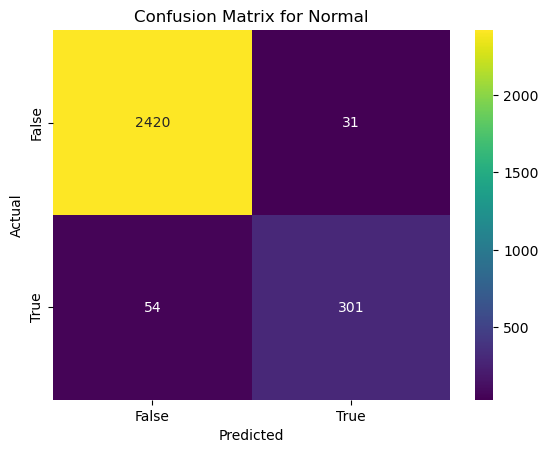

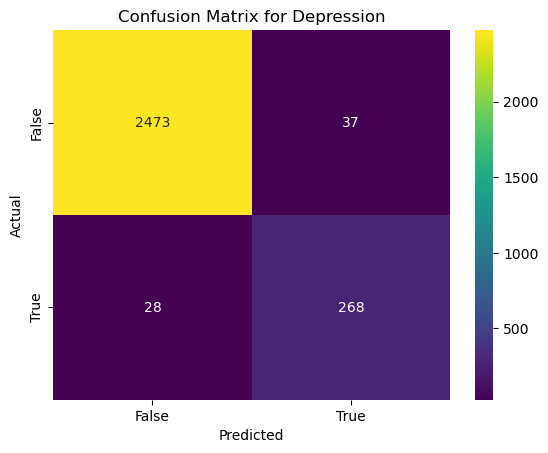

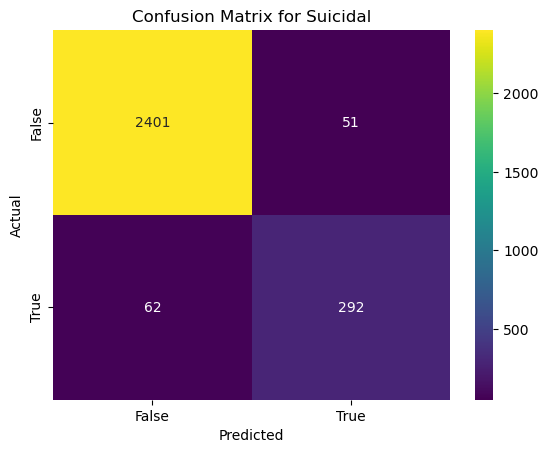

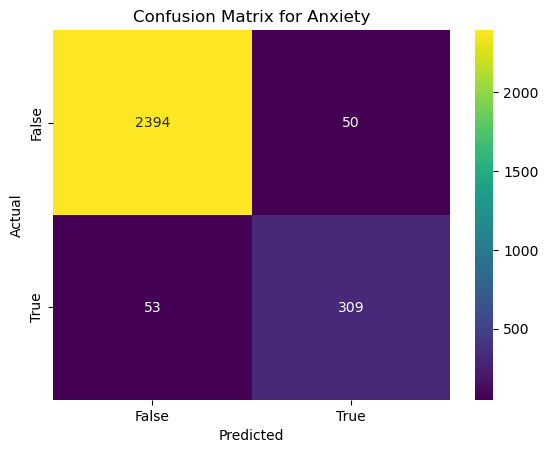

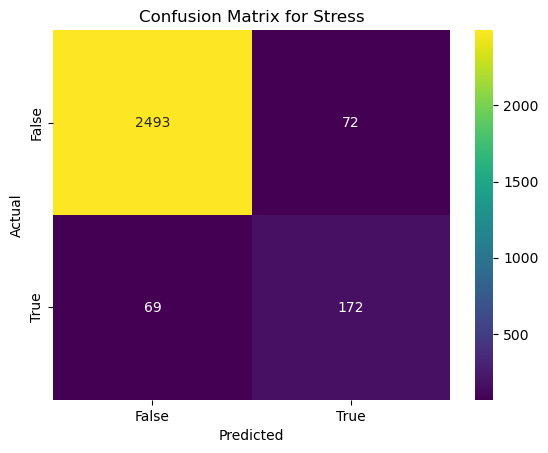

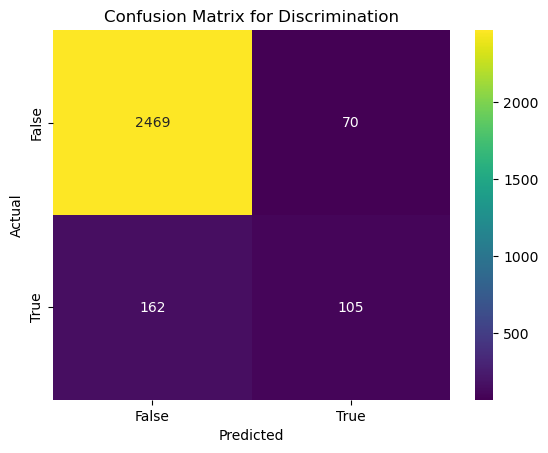

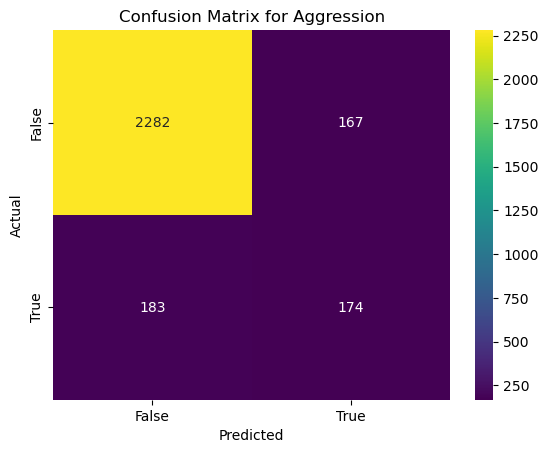

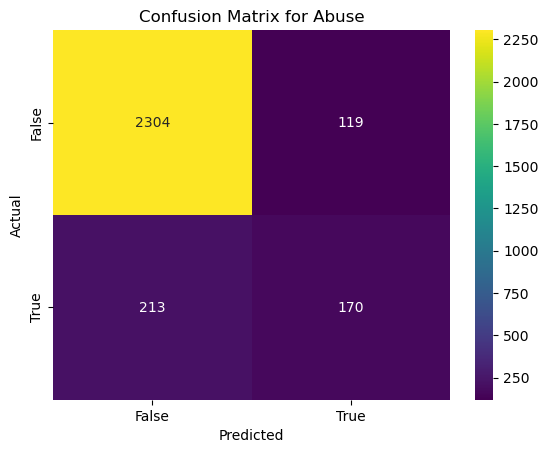

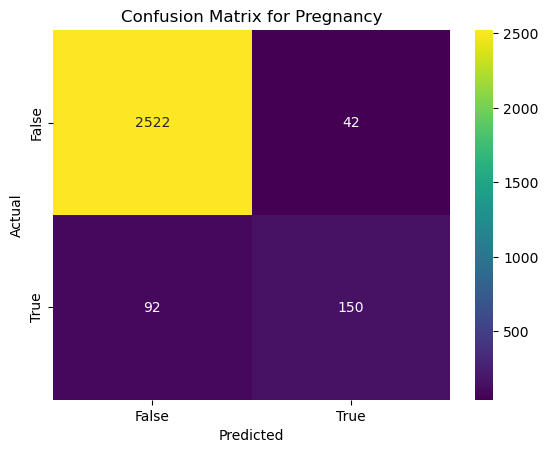

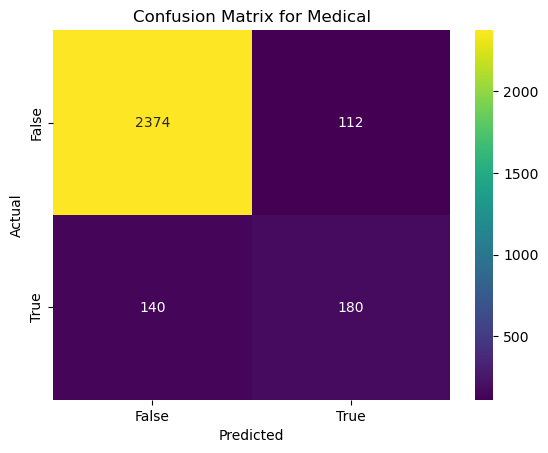

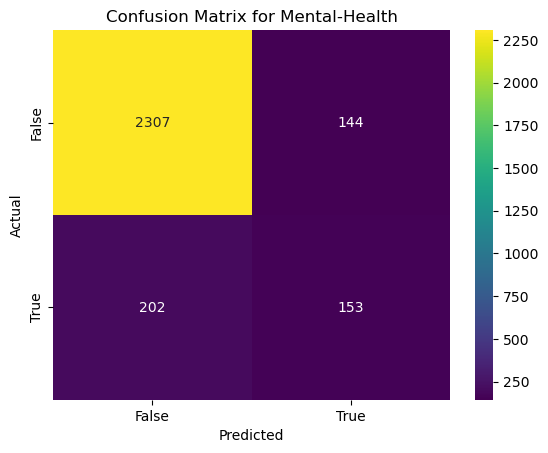

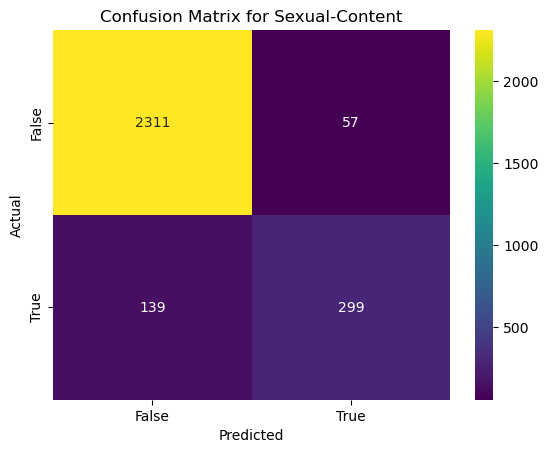

In [62]:
prediction = clf.predict(X_test_vect)

# hamming loss: percentage of time that the prediction is wrong
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))
print('Accuracy Score: ', round(accuracy_score(y_test, prediction), 2))

labels = full_datasets.columns[1:]
for i in range(len(labels)):
    cm_normal = multilabel_confusion_matrix(y_test, prediction)[i]
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='viridis', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {labels[i]}')
    plt.show()